In [2]:
!python -V

Python 3.9.7


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [9]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-greentaxi-trip-prediction")

2022/05/29 11:06:44 INFO mlflow.tracking.fluent: Experiment with name 'nyc-greentaxi-trip-prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-greentaxi-trip-prediction', tags={}>

In [11]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829435

C:\Users\SESA607807\Anaconda3\envs\mlopszoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\SESA607807\Anaconda3\envs\mlopszoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


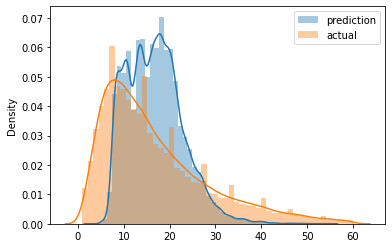

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [14]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [16]:
len(df_train), len(df_val)

(73908, 61921)

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.75871520559622

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [57]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Mahmudul")
    
    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    #Save the model and log the model in the artifacts of the mlflow
    mlflow.log_artifact(local_path="models/linear_regression.bin", artifact_path="models_pickle")

### XGBoost with HyperOpt

In [41]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [48]:
def objective(params):
    
    with mlflow.start_run():
        
        mlflow.set_tag("model", "XGBoost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )
        
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {"loss": rmse, "status": STATUS_OK}

In [ ]:
search_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 4, 100, 1)),
    "learning_rate": hp.loguniform("learning_rate", -3, 0), #interval explored: exp(-3), exp(0), meaning values between [0.05, 1]
    "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
    "reg_lambda": hp.loguniform("reg_lambda", -6, -1),
    "min_child_weight": hp.loguniform("min_child_weight", -3,  -1),
    "objective": "reg:linear",
    "seed": 42
}

best_result = fmin(
    fn=objective, 
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

#### Best param model with autolog

In [59]:
best_params = {
    "learning_rate": 0.2961528266472691,
    "max_depth": 23,
    "min_child_weight": 0.3532816266876489,
    "objective": "reg:linear",
    "reg_alpha": 0.007310478737369701,
    "reg_lambda": 0.36599816506231675,
    "seed": 42
}

mlflow.xgboost.autolog()

best_model = xgb.train(
            params=best_params,
            dtrain = train,
            num_boost_round = 1000,
            evals = [(valid, "validation")],
            early_stopping_rounds = 50
        )

2022/05/29 20:12:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4efcd2e2ffd948ed9100ec1f2bfbe76c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[20:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.97729
[1]	validation-rmse:12.49379
[2]	validation-rmse:10.23772
[3]	validation-rmse:8.82274
[4]	validation-rmse:7.95761
[5]	validation-rmse:7.43287
[6]	validation-rmse:7.11322
[7]	validation-rmse:6.92130
[8]	validation-rmse:6.79580
[9]	validation-rmse:6.71862
[10]	validation-rmse:6.66755
[11]	validation-rmse:6.63226
[12]	validation-rmse:6.60772
[13]	validation-rmse:6.59086
[14]	validation-rmse:6.57919
[15]	validation-rmse:6.57197
[16]	validation-rmse:6.56567
[17]	validation-rmse:6.56023
[18]	validation-rmse:6.55458
[19]	validation-rmse:6.55067
[20]	validation-rmse:6.54677
[21]	validation-rmse:6.54270
[22]	validation-rmse:6.53956
[23]	validation-rmse:6.53762
[24]	validation-rmse:6.53511
[25]	validation-rmse:6.53207
[26]	validation-rmse:6.53058
[27]	validation-rmse:6.52726
[28]	validation-rm

KeyboardInterrupt: 

In [61]:
mlflow.xgboost.autolog(disable=True)

In [62]:
with mlflow.start_run():
    
    best_params = {
        "learning_rate": 0.2961528266472691,
        "max_depth": 23,
        "min_child_weight": 0.3532816266876489,
        "objective": "reg:linear",
        "reg_alpha": 0.007310478737369701,
        "reg_lambda": 0.36599816506231675,
        "seed": 42
    }
    
    mlflow.log_params(best_params)

    best_model = xgb.train(
                params=best_params,
                dtrain = train,
                num_boost_round = 1000,
                evals = [(valid, "validation")],
                early_stopping_rounds = 50
            )
    y_pred = best_model.predict(valid)
    
    #log metric
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.bin", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    #Log the preprocessor
    mlflow.log_artifact("models/preprocessor.bin", artifact_path="preprocessor")
    
    #log model
    mlflow.xgboost.log_model(best_model, artifact_path="models_mlflow")

[22:08:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.97729
[1]	validation-rmse:12.49379
[2]	validation-rmse:10.23772
[3]	validation-rmse:8.82274
[4]	validation-rmse:7.95761
[5]	validation-rmse:7.43287
[6]	validation-rmse:7.11322
[7]	validation-rmse:6.92130
[8]	validation-rmse:6.79580
[9]	validation-rmse:6.71862
[10]	validation-rmse:6.66755
[11]	validation-rmse:6.63226
[12]	validation-rmse:6.60772
[13]	validation-rmse:6.59086
[14]	validation-rmse:6.57919
[15]	validation-rmse:6.57197
[16]	validation-rmse:6.56567
[17]	validation-rmse:6.56023
[18]	validation-rmse:6.55458
[19]	validation-rmse:6.55067
[20]	validation-rmse:6.54677
[21]	validation-rmse:6.54270
[22]	validation-rmse:6.53956
[23]	validation-rmse:6.53762
[24]	validation-rmse:6.53511
[25]	validation-rmse:6.53207
[26]	validation-rmse:6.53058
[27]	validation-rmse:6.52726
[28]	validation-rm

#### Prediciton using the best model

In [64]:
logged_model = 'runs:/1f0e6ede61ca42aeb5824d483d0ccc6a/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

[22:12:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 1f0e6ede61ca42aeb5824d483d0ccc6a

In [65]:
xgboost_model = mlflow.xgboost.load_model(model_uri=logged_model)
xgboost_model

[22:13:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:
y_pred = xgboost_model.predict(valid)
y_pred[:10]

array([15.618392,  7.210269, 14.336551, 23.81602 ,  9.291355, 17.112774,
       11.767075,  8.21778 ,  8.920096, 17.935568], dtype=float32)